# GFS latest 16 day forecast

<b>Table of Contents</b>

- Overview
- Setup
    - Get authentication token
- Data Layer
- Querying the data layers
    - Point query
    - Raster query
- References
  
## Overview

This data set is about numerical weather prediction system that contains a global computer model and variational analysis from the United States National Weather Service (NWS).

## Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample, mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../../../auth/secrets.ini')```

In [ ]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib

In [2]:
import ibmpairs.client as client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import pandas as pd
import configparser
import json
import numpy as np
from PIL import Image as PIL_Image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

Now, let us create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

### Get authentication token

In [4]:
config = configparser.RawConfigParser()
config.read('../../../../auth/secrets.ini')
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY    = config.get('EI', 'api.api_key')
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_ORG_ID     = config.get('EI', 'api.org_id')  

EI_client_v3  = client.get_client(api_key   = EI_API_KEY,
                                    tenant_id = EI_TENANT_ID,
                                    org_id    = EI_ORG_ID,
                                    legacy    = False,
                                    version   = 3
                                   )

2025-01-20 17:01:00 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-01-20 17:01:00 - paw - INFO - Legacy Environment is False
2025-01-20 17:01:00 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-01-20 17:01:02 - paw - INFO - Authentication success.
2025-01-20 17:01:02 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


## Data layers
Let us start by querying the catalog to retrieve the dataset_id and the datalayer that forms the dataset.

In [7]:
pd.set_option('display.max_colwidth', None)
search_df = catalog.search("GFS latest 16 day forecast")
search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short','data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

,dataset_id,data_layer_id,data_layer_name,data_layer_description_short,data_layer_level,data_layer_type,data_layer_unit,data_set_name,data_set_description_short
0,16,16100,Ground temperature,Temperature at 2 m above ground.,11,Raster,K,GFS latest 16 day forecast,Numerical weather prediction system that contains a global computer model and variational analysis from the United States National Weather Service (NWS).
1,16,16200,Ground relative humidity,Relative humidity at 2 m above ground.,11,Raster,%,GFS latest 16 day forecast,Numerical weather prediction system that contains a global computer model and variational analysis from the United States National Weather Service (NWS).
2,16,16300,Solar irradiance,Global global horizontal solar irradiance (shortwave),11,Raster,W m-2,GFS latest 16 day forecast,Numerical weather prediction system that contains a global computer model and variational analysis from the United States National Weather Service (NWS).
3,16,16400,Wind towards east,Wind speed towards east at 10 m above ground.,11,Raster,m s-1,GFS latest 16 day forecast,Numerical weather prediction system that contains a global computer model and variational analysis from the United States National Weather Service (NWS).
4,16,16500,Wind towards north,Wind speed towards north at 10 m above ground.,11,Raster,m s-1,GFS latest 16 day forecast,Numerical weather prediction system that contains a global computer model and variational analysis from the United States National Weather Service (NWS).
5,16,16600,Surface pressure,Surface pressure.,11,Raster,Pa,GFS latest 16 day forecast,Numerical weather prediction system that contains a global computer model and variational analysis from the United States National Weather Service (NWS).
6,16,16700,Average precipitation,Average precipitation.,11,Raster,mm hour-1,GFS latest 16 day forecast,Numerical weather prediction system that contains a global computer model and variational analysis from the United States National Weather Service (NWS).
7,16,48873,Maximum temperature,GFS Global Daily Maximum Temperature,11,Raster,K,GFS latest 16 day forecast,Numerical weather prediction system that contains a global computer model and variational analysis from the United States National Weather Service (NWS).
8,16,48874,Minimum temperature,GFS Global Daily Minimum Temperature,11,Raster,K,GFS latest 16 day forecast,Numerical weather prediction system that contains a global computer model and variational analysis from the United States National Weather Service (NWS).
9,16,49057,Volumetric soil moisture (0 to 10 cm),0-0.1 m below ground liquid volumetric soil moisture (non frozen) [proportion].,11,Raster,m3 m-3,GFS latest 16 day forecast,Numerical weather prediction system that contains a global computer model and variational analysis from the United States National Weather Service (NWS).


As seen above, the Data Set of ID 16 has 15 Data Layers. Each of the Data Layers are identified by a unique Data Layer ID. To gain a better understanding of the Data Set and its geospatial and temporal coverage as well as other relevant metadata, we can make further queries to the catalog submodule as mentioned in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).

## Querying the data layers

### Point query
Next, let us make a point query for locations in different parts of India to observe their climatic conditions.

Note: The dates in the query can either be past or future dates. For the data set that we are querying for right now, future dates can elapse for the next 16 days.

In [55]:
query_result = query.submit(
    {
        "layers" : [
            {
                "type" : "raster",
                "id" : "16100"
            },
            {
                "type" : "raster", 
                "id" : "16200"
            },
            {
                "type" : "raster", 
                "id" : "16300"
            },
            {
                "type" : "raster", 
                "id" : "16400"
            },
            {
                "type" : "raster", 
                "id" : "16500"
            },
            {
                "type" : "raster", 
                "id" : "16600"
            },
            {
                "type" : "raster", 
                "id" : "16700"
            },
            {
                "type" : "raster", 
                "id" : "48873"
            },
            {
                "type" : "raster", 
                "id" : "48874"
            },
            {
                "type" : "raster", 
                "id" : "49057"
            },
            {
                "type" : "raster", 
                "id" : "49058"
            },
            {
                "type" : "raster", 
                "id" : "49059"
            },
            {
                "type" : "raster", 
                "id" : "49060"
            },
            {
                "type" : "raster", 
                "id" : "50294"
            },
            {
                "type" : "raster", 
                "id" : "50305"
            }
        ],
        "spatial" : {
            "type" : "point",
            "coordinates" : [
                16.868900, 75.960471,      # India
                27.671302, 72.758000       # Hami
            ]
        },
        "temporal" : {
            "intervals" : [{
                    "start" : "2025-01-07T00:00:00Z", 
                    "end" : "2025-01-07T00:00:00Z"
                }
            ]
        }
    } , client=EI_client_v3)

point_df = query_result.point_data_as_dataframe()
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] * 1e6, errors = 'coerce')
point_df

2025-01-07T10:34:21Z 2025-01-07T13:34:21Z
2025-01-07 10:34:21 - paw - INFO - TASK: submit STARTING.
2025-01-07 10:34:39 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,timestamp,longitude,latitude,value,datetime
0,16100,Ground temperature,GFS latest 16 day forecast,1736208000000,75.960471,16.868900,292.1102600097656,2025-01-07
1,16100,Ground temperature,GFS latest 16 day forecast,1736208000000,72.758000,27.671302,283.6849670410156,2025-01-07
2,16200,Ground relative humidity,GFS latest 16 day forecast,1736208000000,75.960471,16.868900,48.21199417114258,2025-01-07
3,16200,Ground relative humidity,GFS latest 16 day forecast,1736208000000,72.758000,27.671302,30.7707576751709,2025-01-07
4,16300,Solar irradiance,GFS latest 16 day forecast,1736208000000,75.960471,16.868900,0.0,2025-01-07
5,16300,Solar irradiance,GFS latest 16 day forecast,1736208000000,72.758000,27.671302,0.0,2025-01-07
6,16400,Wind towards east,GFS latest 16 day forecast,1736208000000,75.960471,16.868900,-1.2866473197937012,2025-01-07
7,16400,Wind towards east,GFS latest 16 day forecast,1736208000000,72.758000,27.671302,-0.27951425313949585,2025-01-07
8,16500,Wind towards north,GFS latest 16 day forecast,1736208000000,75.960471,16.868900,0.9308618903160095,2025-01-07
9,16500,Wind towards north,GFS latest 16 day forecast,1736208000000,72.758000,27.671302,-3.1395740509033203,2025-01-07


We see above, various climatic parameters related to Temperature, Solar irradiance, humidity, Wind in different directions are predicted for various locations we queried for. For example, the location we queried within India has a Ground Temperature of 295.22 measured in Kelvin. All the above parameters are measured in their respective SI units.
Note: The comments within the query JSON, intended for descriptive purposes, may cause compatibility issues in other programming languages and should be removed when using the data in those contexts.

### Raster query
Next, let us make a raster query for the area comprising of South of India, to observe the different climatic parameters.

In [49]:
GFS_forecast_result = query.submit_check_status_and_download(
    {
        "publish": True,
        "name": "GFS latest 16 day forecast for part of Asia",
        "spatial": {
            "type": "square",
            "coordinates": [
              27.671302, 72.758000,
              46.218913, 101.922177
            ]
        },
        "temporal": {
            "intervals" : [{
                    "start" : "2025-01-01T00:00:00", 
                    "end" : "2025-01-01T00:00:00"
                }
            ]
        },
        "layers": [
            { 
                "type": "raster", 
                "id": "16100", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "16200", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "16300", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "16400", 
                "output": True
             },
            { 
                "type": "raster", 
                "id": "16500", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "16600", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "16700", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "48873", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "48874", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "49057", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "49058", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "49059", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "49060", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "50294", 
                "output": True
            },
            { 
                "type": "raster", 
                "id": "50305", 
                "output": True
            },
        ]
    }, client=EI_client_v3)

2025-01-07 10:30:12 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-01-07 10:30:13 - paw - INFO - The query was successfully submitted with the id: 1736208000_18013689.
2025-01-07 10:30:14 - paw - INFO - The query 1736208000_18013689 has the status Queued.
2025-01-07 10:30:46 - paw - INFO - The query 1736208000_18013689 has the status Running.
2025-01-07 10:31:17 - paw - INFO - The query 1736208000_18013689 has the status Succeeded.
2025-01-07 10:31:17 - paw - INFO - The query 1736208000_18013689 was successful after checking the status.
2025-01-07 10:31:48 - paw - INFO - The query 1736208000_18013689 has the status Succeeded.
2025-01-07 10:31:48 - paw - INFO - The query 1736208000_18013689 was successful after checking the status.
2025-01-07 10:31:48 - paw - INFO - The query download folder is set to the path /Users/environmental-intelligence/Environmental-Intelligence-internal/geospatial_analytics/v3_apis/samples/industry_use_cases/datasets/gfs_forecast/download/

The query takes a few seconds to complete and downloads the output as a zip file in the /download folder within the same location as this notebook. Now let us display the resultant tiff(s) using the following utility function.

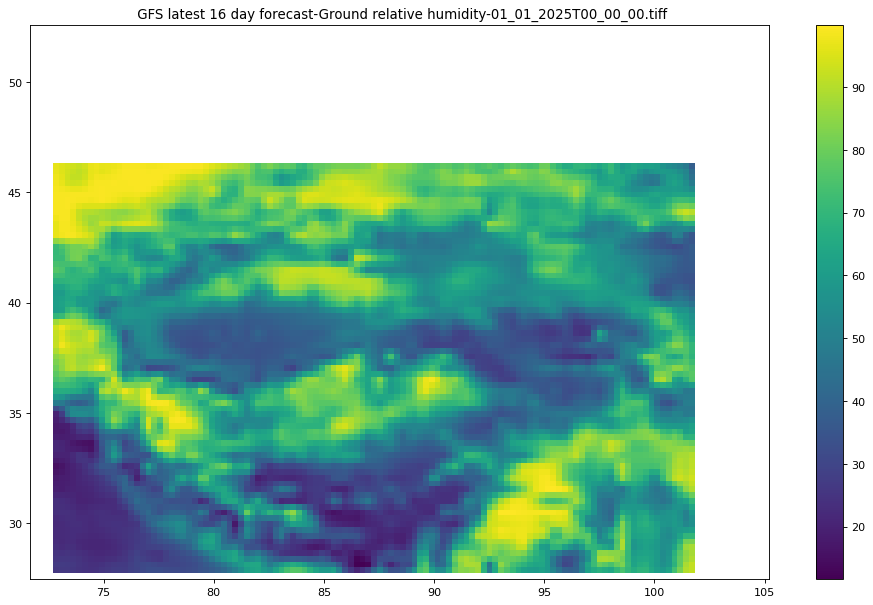

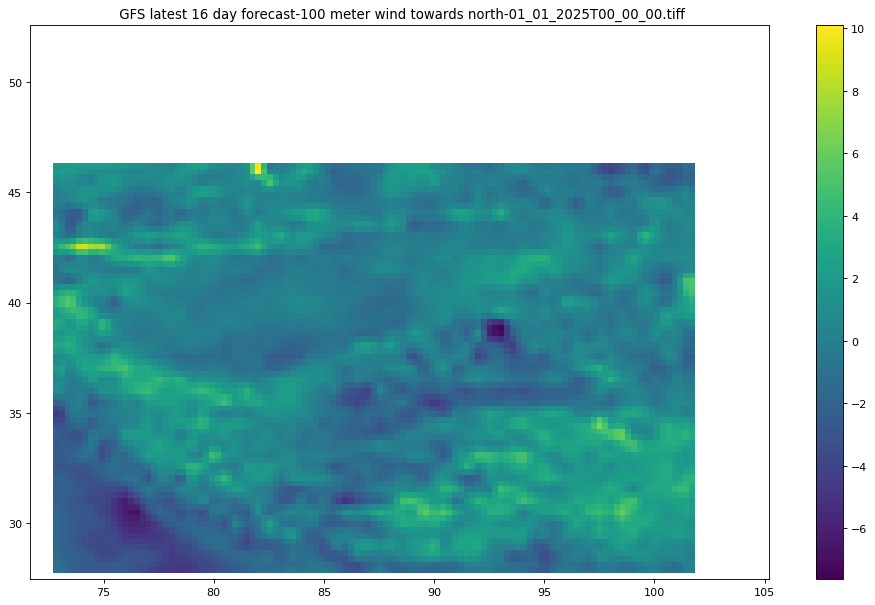

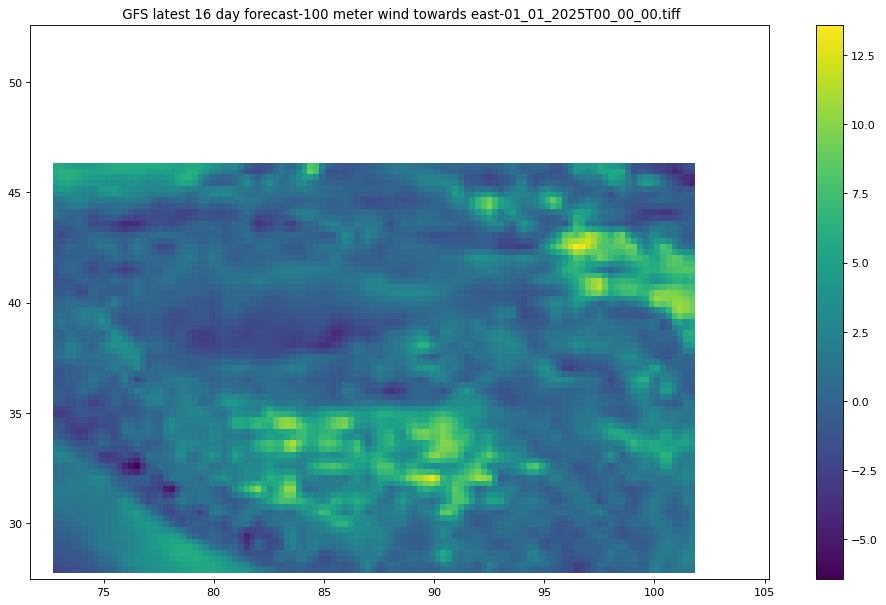

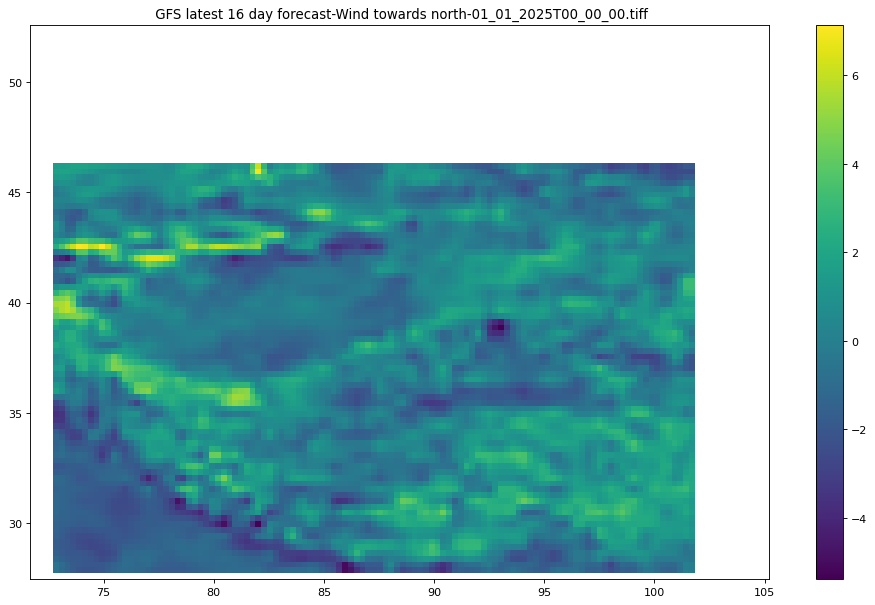

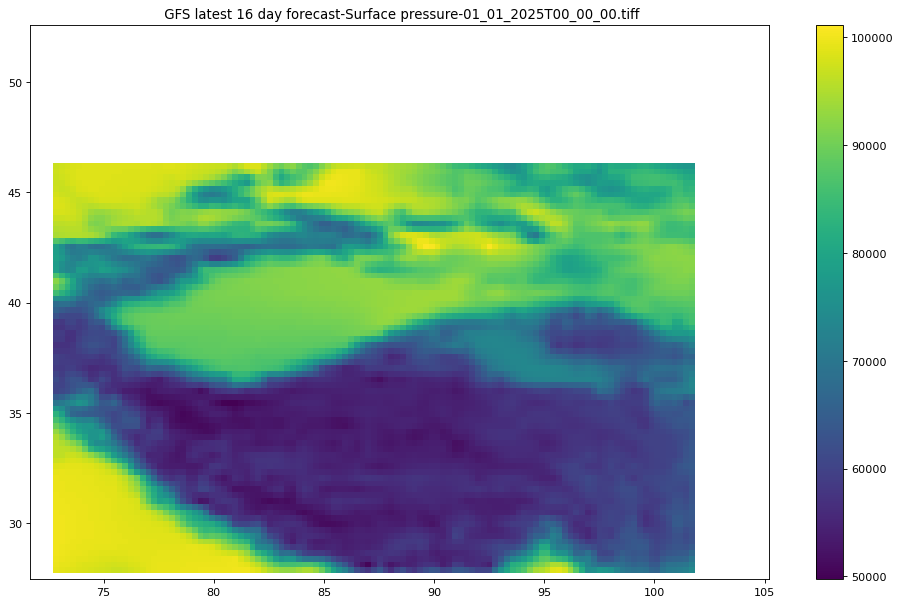

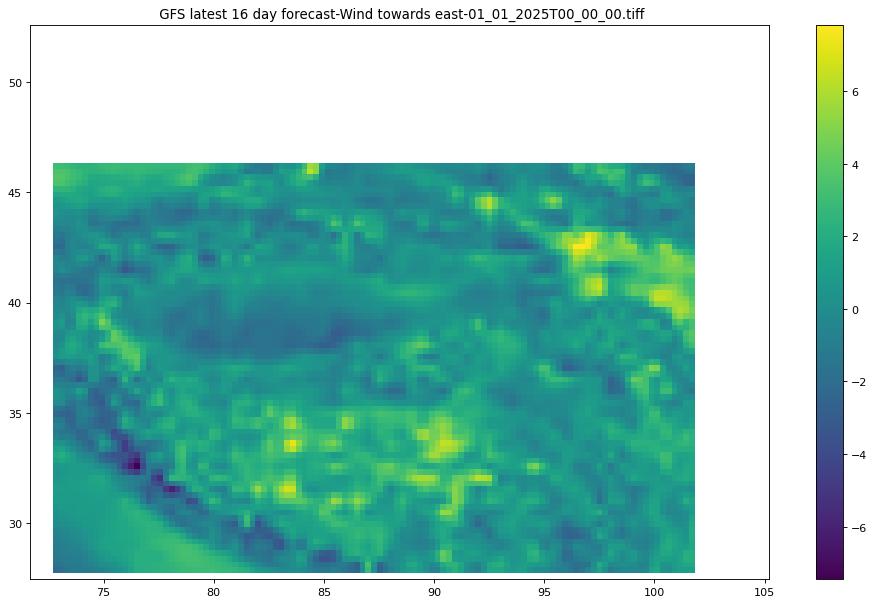

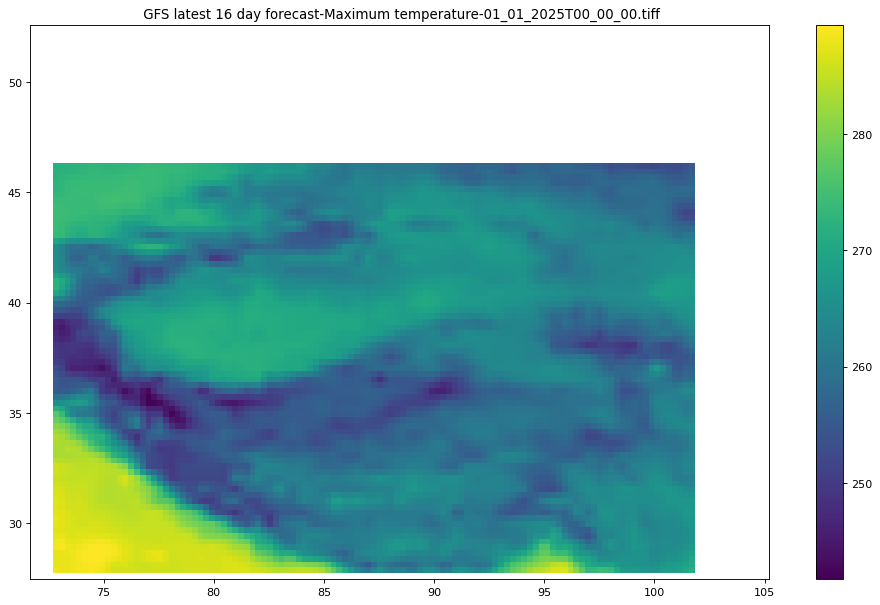

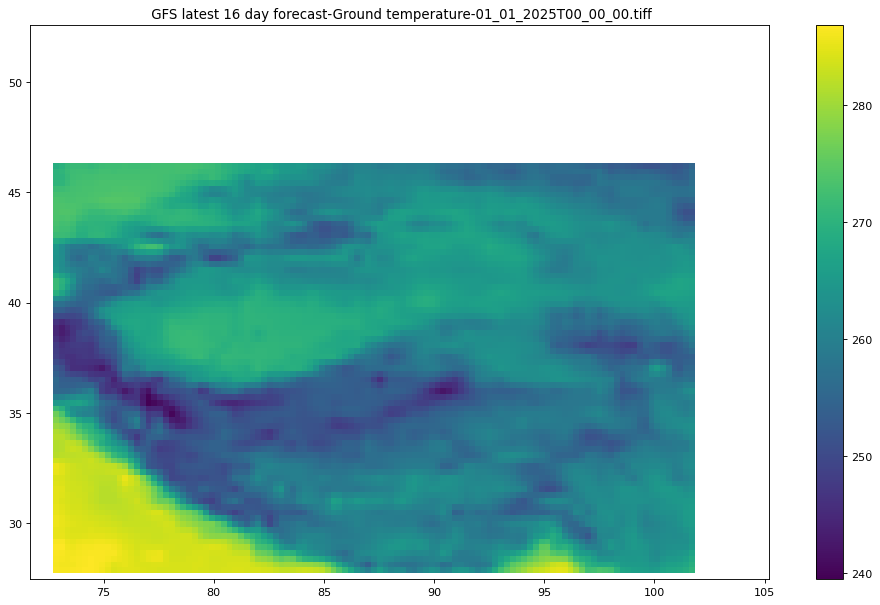

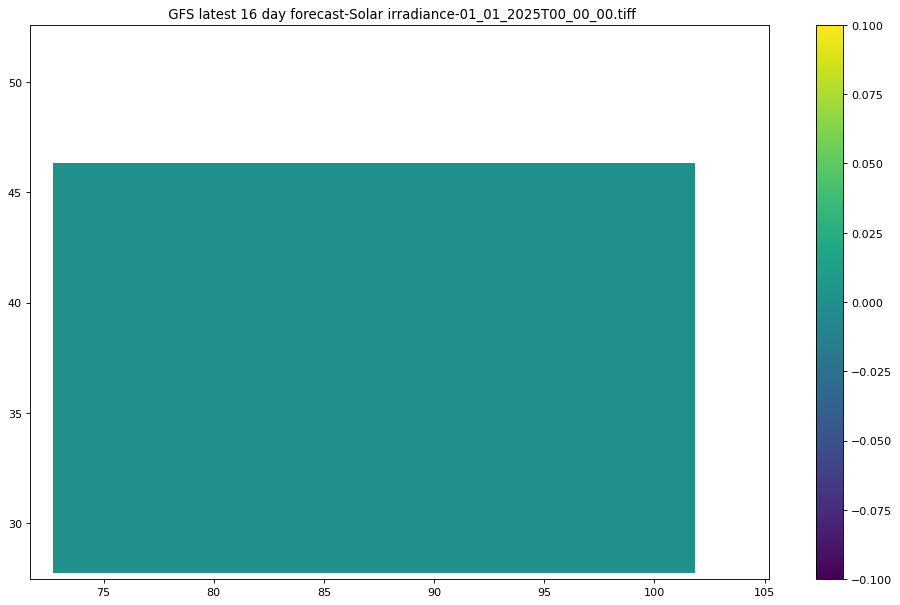

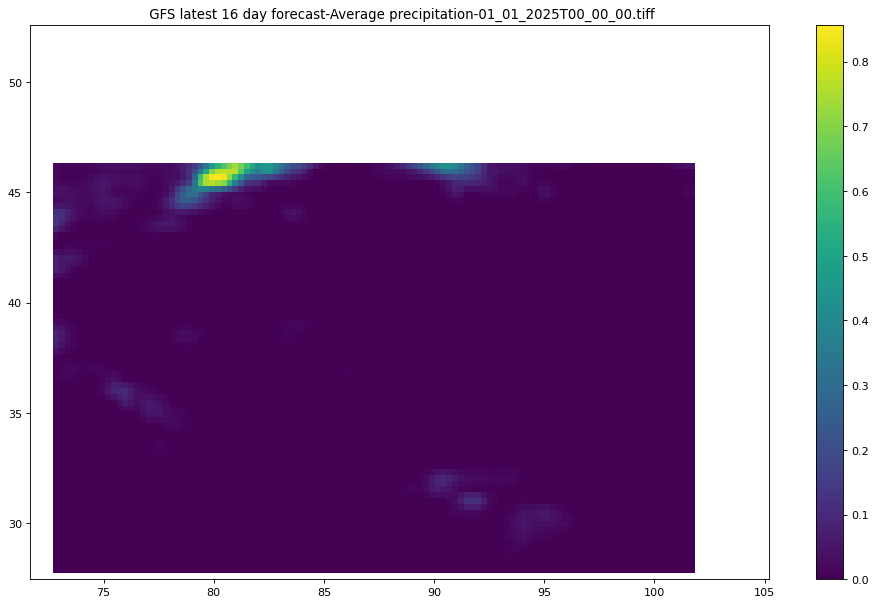

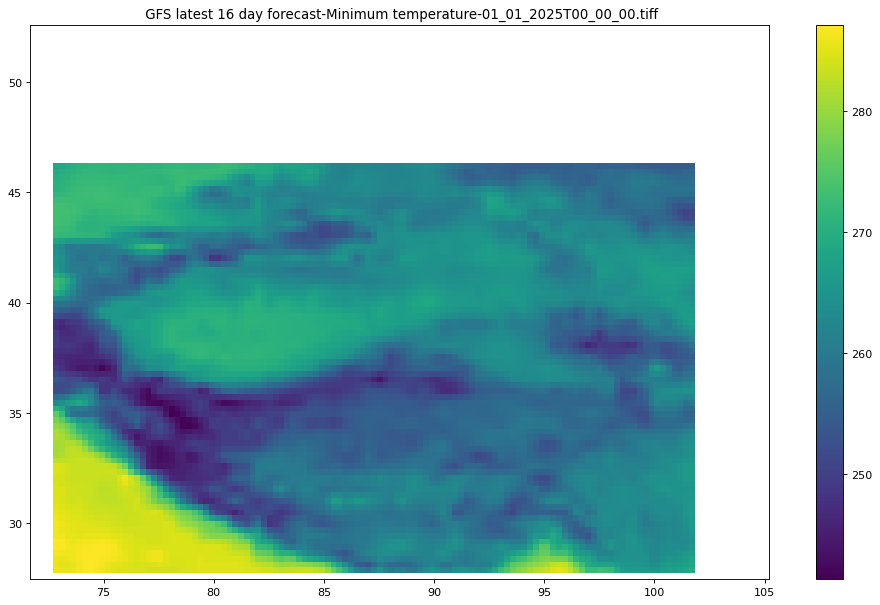

In [56]:
# Function to display the resulting Tiff(s).
GFS_forecast_result_file_list = GFS_forecast_result.list_files()
image_list = []
for file in GFS_forecast_result_file_list:
    if file.endswith('.tiff'): #display the raster images
        with open(file+'.json', 'r') as summary_file:
            fileparms = json.load(summary_file)
        boundingBox=fileparms["boundingBox"]
        pixelStatistics=fileparms["rasterStatistics"]
        myextent=[boundingBox["minLongitude"],
                  boundingBox["maxLongitude"],
                  boundingBox["minLatitude"],
                  boundingBox["maxLatitude" ]]  
        arrayNED = np.array(PIL_Image.open(file))
        mask = (arrayNED == -9999)
        # Masked array to exclude NO Data points from plotting
        masked_array = np.ma.masked_array(arrayNED, mask)
        plt.figure(figsize = (15, 9), dpi=80) # Sets the size and resolution of the plot
        plt.imshow(masked_array,cmap = 'viridis', 
                   vmin=pixelStatistics["pixelMin"], 
                   vmax=pixelStatistics["pixelMax"],
                   extent = myextent) # Loads the raster data and sets the colormap
        cbar = plt.colorbar() # Adds the color bar
        plt.title(" "+os.path.basename(file)) 
        output_image_path = os.path.splitext(os.path.basename(file))[0] + ".png"
        image_list.append(output_image_path)

        # # Save the figure
        plt.savefig(output_image_path, bbox_inches='tight')
        plt.close() 
for image in image_list:
    display(Image(filename=image))

Each of the images above represents information on different climate variables for the specified location and temporal period. The blue area in all the tiff files denotes lower value and transistions to warm yellowish color that denotes higher value for any given parameter.

### References
- https://nomads.ncep.noaa.gov
- https://www.emc.ncep.noaa.gov/emc/pages/numerical_forecast_systems/gfs.php